In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
sns.set_palette("Set2")

import pycountry
import pycountry_convert as pc

import folium

from datetime import datetime

from locationHelper import LocationHelper
from preProcessingHelper import PreProcessRatings

np.random.seed(42)

# Tims analysis: is there a change in the reviews based on the season?

In [17]:
# load dataset and store it for faster use
# we do the analysis for BeerAdvocate

pp = PreProcessRatings(platform="BeerAdvocate")
ratings_df = pp.get_dataframe(dataset="ratings", additinal_cols=["country_name", "country_code3", "state", "date_object", "month", "year"])
ratings_df.to_csv("data/tims_data/beerAdvocateRatings.csv", index=False)

start parsing the beer reviews for BeerAdvocate
finished parsing the beer reviews for BeerAdvocate
start converting datatypes
end converting datatypes
now you can get dataframes with the "get_dataframe" handle
Country svalbard and jan mayen islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country aotearoa could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country fiji islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country heard and mcdonald islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
Country south georgia and south sandwich islands could not be resolved with pycountry fuzzy search.
Try to modify it in polish_country_names()
From 8393032 reviews, 7892754 have a location (corresponding to the user) and 500278 do not have a location


In [3]:
ratings_df = pd.read_csv("data/tims_data/beerAdvocateRatings.csv")

## ratings over the season?

Text(0.5, 1.0, 'Avg rating over the period 1996 - 2017 with 95% confidence interval, n=8393032')

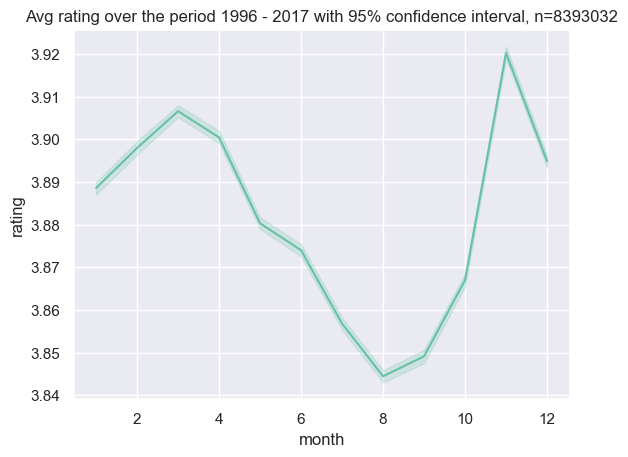

In [20]:
sns.lineplot(ratings_df, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating over the period {ratings_df["year"].min()} - {ratings_df["year"].max()} with 95% confidence interval, n={ratings_df.shape[0]}')

In [ ]:
months = np.sort(ratings_df["month"].unique())
all_months_vals = []
for m in months:
    month_list = [rating for rating in ratings_df[ratings_df["month"] == m]["rating"].values]
    all_months_vals.append(month_list)
    
sns.histplot(all_months_vals[0], kde=True)
all_months_vals[0]

It looks as if the world doesn't rate the beers the same over the year! Why could that be the case? We want to see if it's statistically relevant! 


Our dependent variable is the rating of the beer and our indepenent variable is the month. We want to assess the differences between groups on a continuous measurement with only one independent variable and therefore choose the one-way ANOVA test. First we assess if the data meets the conditions for ANOVA.

$H_0:$ The means of the ratings for all the months are equal. 


$H_A:$ At least one mean of the ratings for a month is different from the rest.

/Users/klusertim/miniforge3/envs/ada/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 726054.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.9328855422823181), pvalue=np.float64(2.9205165978319236e-137))

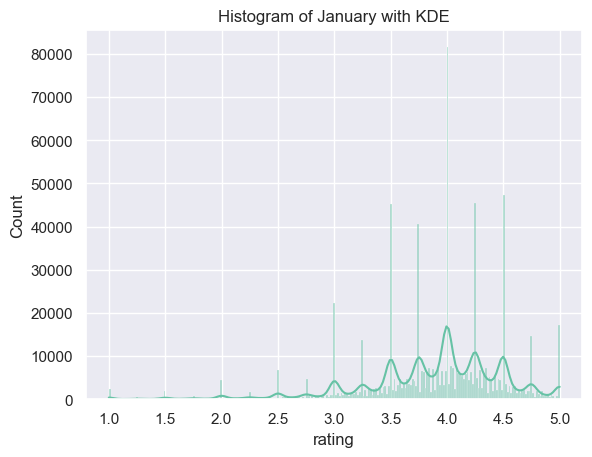

In [86]:
from scipy.stats import shapiro

def get_rating_per_month(df: pd.DataFrame):
    months = np.sort(df["month"].unique())
    all_months_vals = []
    for m in months:
        month_list = [rating for rating in df[df["month"] == m]["rating"].values]
        all_months_vals.append(month_list)
    return all_months_vals

all_months_vals = get_rating_per_month(ratings_df)
h = sns.histplot(all_months_vals[0], kde=True)
h.set_title("Histogram of January with KDE")
h.set_xlabel("rating")
shapiro(all_months_vals[0])

We can already see in the plot that the data of our variables is most likely not normally distributed! Therefore we can't use the ANOVA test. 

We can also see that we have a lot more ratings at every number divisible by 0.25. Therefore we have to round it on the closest 0.25. Therefore the rating is now a discrete dependent variable instead of a continuous as before.

In [ ]:
def round_to_quarter(l: list):
    # rounds to the nearest quarter
    return np.rint(np.array(l) * 4) / 4

months_vals_quarter = list(map(round_to_quarter, all_months_vals))

We can use the Kruskal-Wallis H-test which is a non-parametric version of ANOVA. We do no longer need normality of the data, equal variance and continuous dependent variable. $H_0$ and $H_A$ stay as previously stated.

In [71]:
from scipy.stats import kruskal
kruskal(*months_vals_quarter)

KruskalResult(statistic=np.float64(14402.904169750522), pvalue=np.float64(0.0))

As the p-value is 0.0, we can reject the null hypothesis. It's very likely that at least one mean of the ratings over the months is different.

As pvalue is 0.0 we can reject $H_0$.

Where does this difference come from? Are there people that are easier on the ratings for beers for some seasons compared to others?

### Is this trend the same for every year?
We divide the time span into 5 different eras to plot them.

In [ ]:
from pandas.api.types import CategoricalDtype
n_groups = 5
min_year, max_year = ratings_df["year"].min(), ratings_df["year"].max()
while (max_year - min_year + 1) % n_groups != 0:
    max_year += 1
all_years = np.arange(min_year, max_year+1)
group_size = np.floor(len(all_years) / n_groups)
year_groups = np.split(all_years, group_size)

for yg in year_groups:
    indices = ratings_df[ratings_df["year"].isin(yg)].index
    ratings_df.loc[indices, "year_group"] = f'{yg.min()}-{yg.max()}'
year_group_categories = np.sort(ratings_df["year_group"].unique()) # sorted categories
cat_type = CategoricalDtype(categories=year_group_categories, ordered=True)
ratings_df["year_group"] = ratings_df["year_group"].astype(cat_type)


Text(0.5, 1.0, 'Avg rating over the ears with 95% confidence interval')

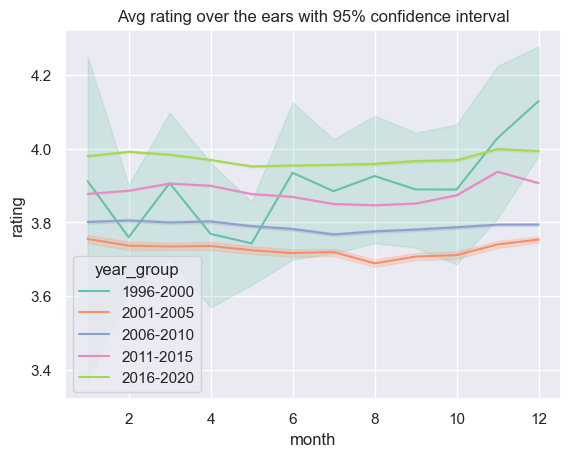

In [84]:
g = sns.lineplot(ratings_df, x="month", y="rating", hue="year_group", estimator="mean", errorbar=("ci", 95))
legend = [yg.get_text() + f', n={ratings_df[ratings_df["year_group"] == yg.get_text()].shape[0]}' for yg in g.get_legend().texts]
plt.title(f'Avg rating over the ears with 95% confidence interval')
#TODO: Here we could do a spider diagram

In [80]:
print('\n'.join(np.sort(legend)))

1996-2000, n=328
2001-2005, n=215467
2006-2010, n=944035
2011-2015, n=5896568
2016-2020, n=1336634


We can see that there isn't a lot of data in the first few years which leads to a high uncertainty. Therefore we'll drop this data and do the investigation from 2001 - 2017. We want to see if we can assume $H_A$ for every year.

In [88]:

ratings_df_new = ratings_df[ratings_df["year_group"] != year_group_categories[0]]
for yg in year_group_categories[1:]:
    rating_per_month = get_rating_per_month(ratings_df[ratings_df["year_group"] == yg])
    months_vals_quarter = list(map(round_to_quarter, rating_per_month))
    print(kruskal(*months_vals_quarter))
    

KruskalResult(statistic=np.float64(197.30792010133572), pvalue=np.float64(2.6905953948403e-36))
KruskalResult(statistic=np.float64(380.3430433992243), pvalue=np.float64(9.061488113346579e-75))
KruskalResult(statistic=np.float64(13251.86236867443), pvalue=np.float64(0.0))
KruskalResult(statistic=np.float64(1406.168722074481), pvalue=np.float64(5.620862722415071e-295))


In [ ]:
# TODO Delete -> this is some testing
from scipy.stats import norm, f_oneway
import random
r = sorted(set(norm.rvs(size=1000)))
chosen = [random.sample(r, 100) for _ in range(10)]
chosen = list(map(round_to_quarter, chosen))
print(kruskal(*chosen))
print(f_oneway(*chosen))


KruskalResult(statistic=np.float64(9.279934928064009), pvalue=np.float64(0.411845414629098))
F_onewayResult(statistic=np.float64(1.0478877939984277), pvalue=np.float64(0.3994872054075038))


Therefore we can reject $H_0$: For every time span, we can reject that the means of the ratings over all months are equal -> for each time span there are at least two months that are different.

## How does it look for different countries?

How does it look in the US, where we have the most data? (the amplitude for the countries on the northern hemisphere must be decreased by the ratings of the southern hemisphere.)

Text(0.5, 1.0, 'Avg rating in the US over the period 1996 - 2017 with 95% confidence interval, n=7303870')

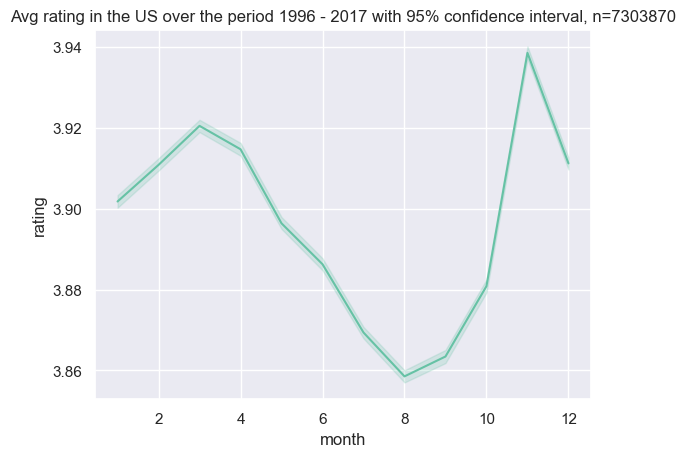

In [65]:
ratings_df_usa = ratings_df[ratings_df["country_code3"] == "USA"]
sns.lineplot(ratings_df_usa, x="month", y="rating", estimator="mean", errorbar=("ci", 95))
plt.title(f'Avg rating in the US over the period {ratings_df_usa["year"].min()} - {ratings_df_usa["year"].max()} with 95% confidence interval, n={ratings_df_usa.shape[0]}')

## distribution of ratings over the world
where the location of the rating is based on the location of the user

In [13]:
ratings_count = ratings_df.groupby("country_code3").agg(nr_ratings=("country_code3", "count")).reset_index()
ratings_count["nr_ratings_log"] = np.log2(ratings_count["nr_ratings"]).replace(-np.inf, 0)

country_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
map = folium.Map(location=[10, 0], zoom_start=1.5)
cp = folium.Choropleth(geo_data=country_geo,
            data=ratings_count,
            columns=['country_code3', 'nr_ratings_log'],
            key_on='feature.id',
            fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
            legend_name="Nr. of ratings (log2 scale)",
            highlight=True

        ).add_to(map)

for s in cp.geojson.data['features']:
      if s['id'] in ratings_count['country_code3'].values:
            s['properties']['nr_ratings'] = (ratings_count[ratings_count["country_code3"] == s['id']]["nr_ratings"]).values[0].astype(str)
      else:
            s['properties']['nr_ratings'] = "0"
      
folium.GeoJsonTooltip(['name', "nr_ratings"]).add_to(cp.geojson)
folium.LayerControl().add_to(map)

map

We take countries with a lot of ratings that are locally separated such as:
- United States of America
- Australia
- Germany
- Sweden
- United Kingdom
- Brazil

<Axes: xlabel='month', ylabel='rating'>

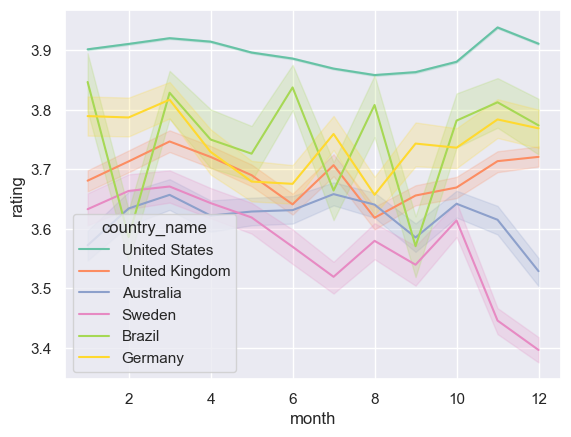

In [168]:
countries_chosen = ["USA", "DEU", "BRA", "GBR", "AUS", "SWE"]
sns.lineplot(ratings_df[ratings_df["country_code3"].isin(countries_chosen)],
             x="month",
             y="rating",
             hue="country_name",
             estimator="mean",
             errorbar=("ci", 95))

What we observe here is that some countries are naturally giving higher ratings than others. We don't want this to disturb our analysis. We're interested in the distribution between seasons. Therefore we should center the data at 0. 

In [170]:
# center the data
means = ratings_df_new.groupby('country_name')['rating'].transform('mean')
ratings_df_new["centered_rating"] = ratings_df_new["rating"] - means

/var/folders/g9/6lh8d5yj335fzgmhtg8p866h0000gn/T/ipykernel_22577/1338941969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df_new["centered_rating"] = ratings_df_new["rating"] - means


<Axes: xlabel='month', ylabel='centered_rating'>

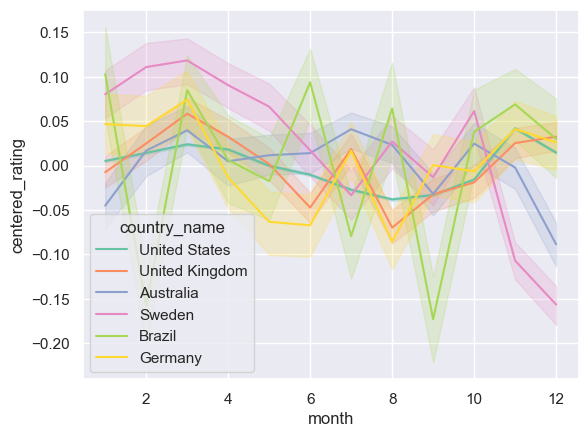

In [172]:
sns.lineplot(ratings_df_new[ratings_df_new["country_code3"].isin(countries_chosen)],
             x="month",
             y="centered_rating",
             hue="country_name",
             estimator="mean",
             errorbar=("ci", 95))

Next steps:
- normalize the data and then 
- Do statistical test on the countries -> i guess we can't reject nullhypothesis that there is no difference between them.
- Then focus on the US to see why there is such a graph
- Maybe we could do something with the slopes.